# KATS GM-RNN

Learn how to make a forecast on the NOAA sample dataset with the pretrained GM-RNN model from Kats. 

## Step One: 
Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
from kats.consts import TimeSeriesData

from kats.models.sarima import SARIMAModel, SARIMAParams
import kats.utils.time_series_parameter_tuning as tpt
from kats.consts import ModelEnum, SearchMethodEnum, TimeSeriesData
from kats.models.arima import ARIMAParams, ARIMAModel
from kats.models.globalmodel.ensemble import GMEnsemble, load_gmensemble_from_file

from ax.core.parameter import ChoiceParameter, FixedParameter, ParameterType
from ax.models.random.sobol import SobolGenerator
from ax.models.random.uniform import UniformGenerator
warnings.simplefilter(action='ignore')


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step Two:
Instantiate the Python Client Libary and build the Flux query. 


In [2]:
client = InfluxDBClient(url="http://localhost:8086", token="RfLcvJ0P8Fr4DZryF_R-HBhO42TouTR3WxnXV-vQXpUYg6Wgv2_kMhxbeNnzYoOYldTqTMgvP7fZJCmhq6TTZg==", org="fa24a6fb5e6d25d0")
write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()

In [3]:
df = query_api.query_data_frame('from(bucket: "noaa")'
  '|> range(start: -100d)'
  '|> filter(fn: (r) => r["_measurement"] == "average_temperature")'
  '|> filter(fn: (r) => r["_field"] == "degrees")'
  '|> filter(fn: (r) => r["location"] == "coyote_creek")'
  '|> aggregateWindow(every: 1d, fn: mean, createEmpty: false)'
  '|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")'
  '|> keep(columns:["_time","degrees"])')

In [4]:
df = df.copy()
df = df.drop(columns=['result', 'table'])
df = df.rename(columns={"_time": "time"})
df.head()

,time,degrees
0,2022-06-29 00:00:00+00:00,79.889140
1,2022-06-30 00:00:00+00:00,79.802083
2,2022-07-01 00:00:00+00:00,80.364583
3,2022-07-02 00:00:00+00:00,79.904167
4,2022-07-03 00:00:00+00:00,80.172917


In [5]:
df_plot = df.set_index('time')

<AxesSubplot:xlabel='time'>

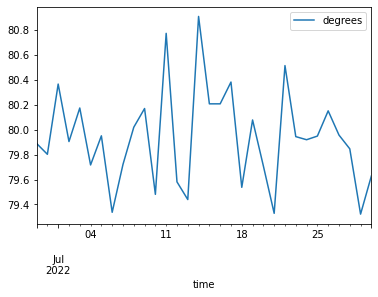

In [6]:
df_plot.plot()

## Step Three: 
Reformat timestamp.

In [7]:
df["time"] = df["time"].apply(lambda x: x.strftime('%Y-%m-%d'))
df = df.head(30)

# Step Four: 
Split into train and test

In [8]:
train = df.head(27)
test = df.tail(3).reset_index(drop=True)

In [9]:
df_ts = TimeSeriesData(train)

## Step Five:
Load model and create forecast. 

In [10]:
gme_rnn = load_gmensemble_from_file("models/pretrained_daily_rnn.p")
gme_rnn

In [11]:
fcsts = gme_rnn.predict(df_ts, steps = 3)

In [12]:
fcsts_df = list(fcsts.items())[0][1]
fcsts_df

,fcst_quantile_0.5,fcst_quantile_0.01,fcst_quantile_0.05,fcst_quantile_0.95,fcst_quantile_0.99,time
0,80.012970,77.467003,78.521225,81.357292,82.351753,2022-07-26
1,79.947342,76.499969,77.853577,81.896912,83.031448,2022-07-27
2,80.016144,75.737137,77.570724,82.271881,83.840042,2022-07-28


In [13]:
fcsts_df = fcsts_df.join(test["degrees"])
fcsts_df.head()
# fcsts_df.plot()

,fcst_quantile_0.5,fcst_quantile_0.01,fcst_quantile_0.05,fcst_quantile_0.95,fcst_quantile_0.99,time,degrees
0,80.012970,77.467003,78.521225,81.357292,82.351753,2022-07-26,80.150000
1,79.947342,76.499969,77.853577,81.896912,83.031448,2022-07-27,79.956250
2,80.016144,75.737137,77.570724,82.271881,83.840042,2022-07-28,79.845833


In [15]:
fcsts_df = fcsts_df[['fcst_quantile_0.5', 'time']]

## Step Six:
Write data with the client library. 

In [16]:
write_api.write(bucket="noaa",
               record=fcsts_df,
               data_frame_measurement_name="forecast",
               data_frame_timestamp_column="time")